In [1]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:

!pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [3]:
!pip install transformers[torch] -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 28.2 MB/s eta 0:00:00


In [4]:
!pip install accelerate==0.27.2 -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import torch
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    classification_report,
)
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import DataLoader
import torch
from torch import nn
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("data/data.csv")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_weights = (1 - (df["labels"].value_counts().sort_index() / len(df))).values
class_weights = torch.from_numpy(class_weights).float().to(device)


class_weights


tensor([0.9931, 0.9891, 0.9852, 0.9842, 0.9871, 0.9891, 0.9486, 0.8823, 0.9980,
        0.9980, 0.9980, 0.9862, 0.9891, 0.9832, 0.9871, 0.9862, 0.9852, 0.9951,
        0.9960, 0.9990, 0.9881, 0.9891, 0.9871, 0.9871, 0.9802, 0.9723, 0.9881,
        0.9871, 0.9941, 0.9891, 0.9862, 0.9832, 0.9881, 0.9871, 0.9832, 0.9842,
        0.9842, 0.9842, 0.9842, 0.9842, 0.9862, 0.9842, 0.9921, 0.9891, 0.9911,
        0.9881, 0.9891, 0.9743, 0.9871, 0.9990, 0.9941, 0.9881, 0.9911, 0.9921,
        0.9921, 0.9921, 0.9871, 0.9862, 0.9852, 0.9911, 0.9911, 0.9881],
       device='cuda:0')

In [8]:
from datasets import load_dataset, Dataset, ClassLabel
import pandas as pd

def get_dataset(csv_path, test_size=0.35, min_samples_per_class=2):
    # Загрузка данных
    full_dataset = load_dataset("csv", data_files=csv_path)["train"]

    # Фильтрация пустых значений
    full_dataset = full_dataset.filter(
        lambda example: example["text_full"] is not None and example["labels"] is not None
    )

    # Подсчет количества образцов для каждого класса
    df = full_dataset.to_pandas()
    class_counts = df['labels'].value_counts()

    # Исключение классов с недостаточным количеством образцов
    valid_classes = class_counts[class_counts >= min_samples_per_class].index.tolist()
    filtered_df = df[df['labels'].isin(valid_classes)]

    # Преобразование столбца labels в ClassLabel
    unique_labels = filtered_df['labels'].unique().tolist()
    class_label = ClassLabel(num_classes=len(unique_labels), names=unique_labels)

    # Преобразование столбца labels в числовые значения
    filtered_df['labels'] = filtered_df['labels'].apply(lambda x: class_label.str2int(x))

    # Создание нового набора данных
    filtered_dataset = Dataset.from_pandas(filtered_df)

    # Обновление информации о характеристиках набора данных
    filtered_dataset = filtered_dataset.cast_column("labels", class_label)

    # Разделение данных на обучающую и тестовую выборки
    dataset = filtered_dataset.train_test_split(test_size=test_size, stratify_by_column="labels")

    return dataset


In [9]:
dataset = get_dataset("data/data.csv")
labels = sorted(df["labels"].value_counts().keys())

id2label = {}
label2id = {}
for i, label in enumerate(labels):
    id2label[i] = label
    label2id[label] = i

model_name = "DeepPavlov/rubert-base-cased"


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/1011 [00:00<?, ? examples/s]

<ipython-input-8-d9b37db9e09b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['labels'] = filtered_df['labels'].apply(lambda x: class_label.str2int(x))


Casting the dataset:   0%|          | 0/878 [00:00<?, ? examples/s]

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_full', 'labels', '__index_level_0__'],
        num_rows: 570
    })
    test: Dataset({
        features: ['text_full', 'labels', '__index_level_0__'],
        num_rows: 308
    })
})

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:

def preprocess_function(examples):
    return tokenizer(examples["text_full"], truncation=True)


In [13]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/570 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

In [14]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(labels), id2label=id2label, label2id=label2id
)

model.to(device)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [15]:
from transformers import AdamW, get_scheduler

dataset_len = dataset["train"].num_rows + dataset["test"].num_rows

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 32
num_training_steps = num_epochs * dataset_len

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_epochs * dataset_len),
    num_training_steps=num_training_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = []

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        self.loss_history.append(loss.item())
        return (loss, outputs) if return_outputs else loss

In [17]:
f1_metric = evaluate.load("f1")

training_args = TrainingArguments(
    output_dir="./results/multiclass-rubert/",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=200,
    weight_decay=0.01,
    logging_strategy="no",
    evaluation_strategy="steps",
    eval_steps=50,
    save_only_model=True,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=2,
    metric_for_best_model="f1",
    greater_is_better=True,
    eval_accumulation_steps=32,
    fp16=True,  # mixed precision
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(
        predictions=predictions, references=labels, average="macro"
    )


In [19]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=[optimizer, lr_scheduler],
)

trainer.train()

Step,Training Loss,Validation Loss,F1
50,No log,4.138496,0.005229
100,No log,4.090469,0.013468
150,No log,4.011868,0.022421
200,No log,3.909536,0.019638
250,No log,3.772106,0.030182
300,No log,3.621334,0.046446
350,No log,3.458085,0.065014
400,No log,3.244345,0.096627
450,No log,3.009103,0.171272
500,No log,2.766768,0.371653


TrainOutput(global_step=768, training_loss=3.2471326192220054, metrics={'train_runtime': 181.1402, 'train_samples_per_second': 100.695, 'train_steps_per_second': 4.24, 'total_flos': 484418053889280.0, 'train_loss': 3.2471326192220054, 'epoch': 32.0})

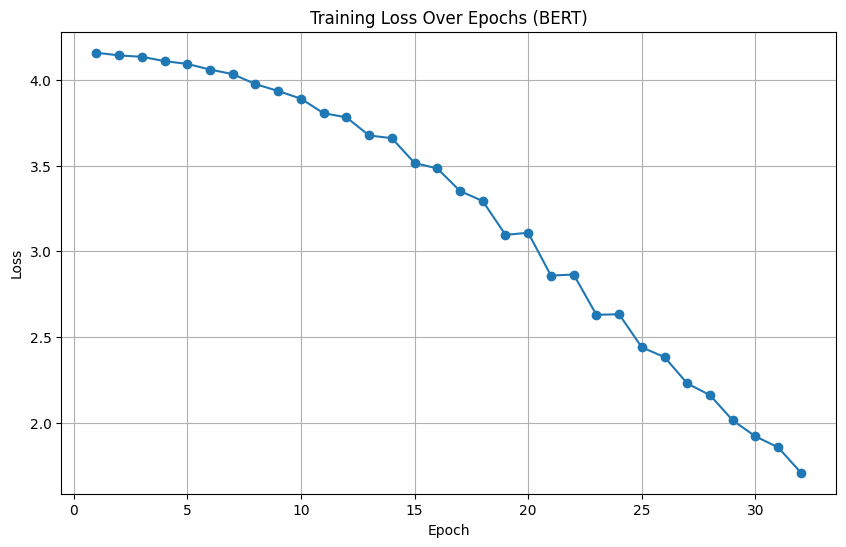

In [23]:
loss_history = trainer.loss_history
steps_per_epoch = len(loss_history) // num_epochs

# Пересчитываем средние значения потерь для каждой эпохи
epoch_losses = [
    sum(loss_history[i*steps_per_epoch:(i+1)*steps_per_epoch]) / steps_per_epoch
    for i in range(num_epochs)
]

# Построение графика функции потерь по эпохам
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [24]:
from tqdm import tqdm


y_pred = []
y_true = tokenized_dataset["test"]["labels"]
with torch.no_grad():
    for i in tqdm(range(len(tokenized_dataset["test"]))):
        logits = model(
            **tokenizer(
                tokenized_dataset["test"][i]["text_full"],
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ).to(device)
        )

        predicted_class_id = logits.logits.argmax().item()
        # model.config.id2label[predicted_class_id]

        y_pred.append(predicted_class_id)

100%|██████████| 308/308 [00:03<00:00, 78.49it/s]


In [25]:
print(f1_score(y_true, y_pred, average="macro",zero_division=0))
print(recall_score(y_true, y_pred, average="macro",zero_division=0))
print(precision_score(y_true, y_pred, average="macro",zero_division=0))

print(classification_report(y_true, y_pred,zero_division=0))


0.7769049717546109
0.7944444444444444
0.7803134920634921
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        18
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       1.00      0.83      0.91         6
           4       0.86      1.00      0.92         6
           5       1.00      0.67      0.80         6
           6       0.75      1.00      0.86         6
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         6
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         4
          11       0.62      1.00      0.77         5
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.60      1.00      0.75         6
          15       0.00      0.00      0.00         3
          16       0.67 

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# Копирование файлов на Google Drive
!cp -r /content/results /content/drive/MyDrive/